# Pathway Analysis
#### Chelsea Alvarado
* not complete
* you must change column names, values, etc to match your pathway youre looking at

In [289]:
import pandas as pd

### Data read in/creation

##### Read in from existing CSV

In [268]:
#read in data frame
#main df for full file
one_hop = pd.read_csv('TrueCX1Hop_6-22.csv')
one_hop
one_hop.columns = ['Non-oAL_ID','Non-oAL_Type','Weight1','Interneuron_ID','Interneuron_Type','Weight2','CX_ID','CX_Type']
one_hop = one_hop.drop(['Non-oAL_Type','Interneuron_Type','CX_Type'], axis=1)

#df with interneuron duplicates removed for a to b
atob_unique = one_hop[['Non-oAL_ID','Weight1','Interneuron_ID']].drop_duplicates()

#### Run query (only run if you don't have CSV file)

In [ ]:
from neuprint import Client, fetch_custom

c = Client('neuprint-test.janelia.org', dataset='hemibrain', token = token, verify=True)

token = ""

starting_body_list = []

def createQueryDataframe():
    #basic one hop query from a starter list to a CX neuron. 
    query = fetch_custom("""\
    WITH """ + str(starting_body_list) + """ AS TARGETS
    MATCH (a:Neuron)-[w:ConnectsTo]->(b:Neuron)-[ww:ConnectsTo]->(c:Neuron)
    WHERE a.bodyId IN TARGETS AND c.`CX` AND w.weight > 9 AND ww.weight > 9
    RETURN a.bodyId, a.type, w.weight, b.bodyId, b.type, ww.weight, c.bodyId, c.type""")
    return query

one_hop = createQueryDataframe()

In [ ]:
#format df
one_hop.columns = ['Non-oAL_ID','Non-oAL_Type','Weight1','Interneuron_ID','Interneuron_Type','Weight2','CX_ID','CX_Type']
one_hop = one_hop.drop(['Non-oAL_Type','Interneuron_Type','CX_Type'], axis=1)

#df with interneuron duplicates removed for a to b
atob_unique = one_hop[['Non-oAL_ID','Weight1','Interneuron_ID']].drop_duplicates()

#### Create multi index dataframe

In [269]:
#create multiindex of main df
onehop_multi = one_hop.set_index(['Non-oAL_ID','Interneuron_ID'])
onehop_multi

Weight1  Weight2       CX_ID
Non-oAL_ID Interneuron_ID                              
603785283  758636869            17       12   789308735
           480258208            10       19  1050935614
           480258208            10       16   953414780
           480258208            10       11  5813087837
           358264919            15       12   922069357
...                            ...      ...         ...
1755556097 702364805            10       34  5813062858
5813056072 702364805            23       18   513784136
           702364805            23      132  5813047763
           702364805            23       34  5813062858
           1671608112           31       12   732034061

[236 rows x 3 columns]

In [283]:
#multiindex cx to non oal
ctoa =one_hop[['CX_ID', 'Weight2', 'Non-oAL_ID']]

reverse = ctoa.set_index(['CX_ID','Non-oAL_ID']).sort_values('CX_ID')
reverse

,,Weight2
CX_ID,Non-oAL_ID,
294450495,5813063239,18
294800293,1858901026,10
295116205,5813063239,17
295141570,5813063239,19
295819960,5813063239,24
...,...,...
5813078563,1944502935,33
5813081818,1858901026,11
5813087837,1975878958,11


### Break up main dataframe into smaller dataframes
* a->b->c
* creates data frames for each chunk of one hop relationship (a to , b to c)
* creates dataframes for other possible relationships ( c to a, b to a, c to b)

In [284]:
# create smaller data frames
#df for sensory to interneuron(a to b)
atob = atob_unique[['Non-oAL_ID','Weight1','Interneuron_ID']]
#multi index
atob_multi = atob.set_index(['Non-oAL_ID','Interneuron_ID'])

#df for interneuron to CX (b to c)
btoc = one_hop[['Interneuron_ID','Weight2','CX_ID']].drop_duplicates()
#multi index 
btoc_multi = btoc.set_index(['Interneuron_ID','CX_ID'])

#df for interneurons (b to a)
inter = one_hop[["Interneuron_ID","Weight1","Non-oAL_ID"]].drop_duplicates()
#multindex
inter_multi = inter.set_index(['Interneuron_ID', 'Non-oAL_ID']).sort_values('Interneuron_ID')

#df for Cx to inter(c to b)
ctob = one_hop[['Interneuron_ID','Weight2','CX_ID']].drop_duplicates()
#multi index 
ctob_multi =ctob.set_index(['CX_ID','Interneuron_ID'])

#for cx to oal (c to a)
ctoa =one_hop[['CX_ID', 'Weight2', 'Non-oAL_ID']].drop_duplicates()
#multi index
ctoa_multi = ctoa.set_index(['CX_ID','Non-oAL_ID']).sort_values('CX_ID')


### Data Operations

In [271]:
#calculate downstream neuron counts
#sensory to inter count ie how many inter neurons the sensory body connects to
downstream_sense = atob.groupby(['Non-oAL_ID','Interneuron_ID']).count()\
       .reset_index().groupby('Non-oAL_ID')['Interneuron_ID'].nunique()

#inter to CX count ie how many cx neurons the inter body connects to
downstream_inter = btoc.groupby(['Interneuron_ID', 'CX_ID']).count()\
       .reset_index().groupby('Interneuron_ID')['CX_ID'].nunique()

In [287]:
#calculate upstream neurons

#calculate upstream inter to sensory b to a
upstream_inter = inter_multi.groupby(['Interneuron_ID', 'Non-oAL_ID']).count()\
        .reset_index().groupby('Interneuron_ID')['Non-oAL_ID'].nunique()

#calculate upstream cx to inter c to b
upstream_cx = ctob_multi.groupby(['CX_ID', 'Interneuron_ID']).count()\
        .reset_index().groupby('CX_ID')['Interneuron_ID'].nunique()

upstream_sense = ctoa_multi.groupby(['CX_ID', 'Non-oAL_ID']).count()\
        .reset_index().groupby('CX_ID')['Non-oAL_ID'].nunique()

#### Interneuron count
* Keeping track of how many times an interneuron shows up in the one hop pathway relationship
* two different methods you can use

In [215]:
#how many times an interneuron body is involved in a one hop pathway (a->b->c) not unique
# method 1
inter = dict()
for i in range(0, len(one_hop['Interneuron_ID'])):
    
    if one_hop['Interneuron_ID'][i] not in inter: 
        
        inter[one_hop['Interneuron_ID'][i]] = 1
          
    else:
        inter[one_hop['Interneuron_ID'][i]] =  inter[one_hop['Interneuron_ID'][i]] + 1

inter

{758636869: 1,
 480258208: 9,
 358264919: 2,
 447599745: 3,
 666916874: 2,
 5813020846: 12,
 511349908: 39,
 357224041: 36,
 667241165: 18,
 386847799: 1,
 388881226: 4,
 452689494: 2,
 5813078641: 6,
 483720758: 2,
 330246657: 1,
 388924424: 7,
 295482551: 5,
 5813011660: 1,
 576825965: 1,
 1671608112: 5,
 1723506321: 6,
 1858901026: 3,
 5813047683: 12,
 850717220: 3,
 787227302: 2,
 389311717: 20,
 5813020673: 1,
 5813022453: 2,
 5813055862: 1,
 5813055709: 16,
 487144598: 3,
 640596169: 1,
 702364805: 9}

In [216]:
#how many times an interneuron body is involved in a one hop pathway (a->b->c) not unique

# method 2
counts = dict()
for i in one_hop['Interneuron_ID']:
    counts[i] = counts.get(i, 0) + 1
    
counts

{758636869: 1,
 480258208: 9,
 358264919: 2,
 447599745: 3,
 666916874: 2,
 5813020846: 12,
 511349908: 39,
 357224041: 36,
 667241165: 18,
 386847799: 1,
 388881226: 4,
 452689494: 2,
 5813078641: 6,
 483720758: 2,
 330246657: 1,
 388924424: 7,
 295482551: 5,
 5813011660: 1,
 576825965: 1,
 1671608112: 5,
 1723506321: 6,
 1858901026: 3,
 5813047683: 12,
 850717220: 3,
 787227302: 2,
 389311717: 20,
 5813020673: 1,
 5813022453: 2,
 5813055862: 1,
 5813055709: 16,
 487144598: 3,
 640596169: 1,
 702364805: 9}

#### Calculate the combined weights

In [ ]:
#sum(combined) weights

#from non-oAL to inter
sum_atob = atob_multi.sum(level = 'Non-oAL_ID').sort_values(by = 'Non-oAL_ID')

#inter to nonoOAL
sum_btoa = inter_multi.sum(level = "Interneuron_ID").sort_values(by = 'Interneuron_ID')

#from inter to cx
sum_btoc = btoc_multi.sum(level = "Interneuron_ID").sort_values(by = 'Interneuron_ID')

#cx to inter
sum_ctob = ctob_multi.sum(level = "CX_ID").sort_values(by = 'CX_ID')

#cx to non-oal
sum_ctoa = ctoa_multi.sum(level = "CX_ID").sort_values(by = 'CX_ID')

## Direct Relationship

#### Read in CSV file

In [313]:
direct = pd.read_csv('direct final.csv')
direct = direct.reset_index().groupby(['Non-oAL Sensory Neurons', 'True CX Neurons'])['c.weight'].aggregate('first').unstack().fillna(0).astype(int)

#### Run query and create DF

In [ ]:
body_list = []
def create_query_dataframe():
    query=fetch_custom("""\
    WITH """ + str(body_list) + """ AS TARGETS
    MATCH (a:Neuron)-[c:ConnectsTo]->(b:Neuron)
    WHERE a.bodyId IN TARGETS AND b.`CX`
    RETURN a.bodyId AS SENSORY, a.type AS SENSORY_TYPE, b.bodyId AS True_CX, b.type AS CX_Type, c.weight AS WEIGHT
    ORDER BY b.bodyId DESC
    """) 
    return query

# store the results as "df_direct"
direct = create_query_dataframe()

In [314]:
direct

True CX Neurons,513784136,667931999,670651346,700999023,730337785,760686202,789308735,949045811,977995787,1131831990,1168625046,1224595644,1255289329,1255979929,5813055834,5813078563
Non-oAL Sensory Neurons,,,,,,,,,,,,,,,,
603785283,0,0,0,2,4,0,14,13,11,0,1,0,14,0,1,5
850717220,0,0,0,0,2,1,15,9,8,0,1,2,14,0,0,14
1639234609,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1858901026,11,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1943812176,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2069648663,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5813040515,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0
5813063239,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0


### Visualization (Heatmap)

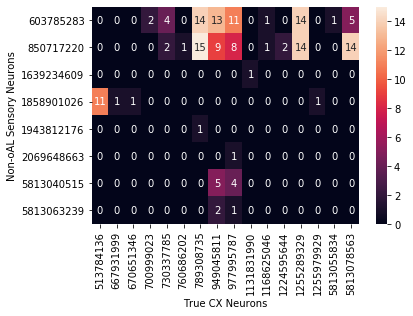

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
#by body id
heat = sns.heatmap(direct,annot = True)
plt.show()

In [321]:
#by type
direct_type = pd.read_csv('Direct Final Type.csv')
direct_type = direct_type.reset_index().groupby(['Sensory Type', 'CX Type'])['SUM_WEIGHT'].aggregate('first').unstack().fillna(0).astype(int)

In [322]:
direct_type

CX Type,FB1G,FB2E,FB2F_a,FB2F_c,FB2H_a,FB2I_a,FB2I_b,FB2J,FB4E,FB6A,FB8B
Sensory Type,,,,,,,,,,,
VP1d_il2PN,0,0,0,0,0,0,0,0,1,0,0
VP1l+VP3_ilPN,0,1,0,2,14,14,15,4,0,1,13
VP1m+VP2_lvPN2,0,0,0,0,0,0,1,0,0,0,0
VP1m+VP5_ilPN,0,0,0,0,0,0,0,0,0,0,1
VP2+_adPN,11,0,1,0,0,1,0,1,0,0,0
VP3+VP1l_ivPN,0,0,0,0,0,0,0,0,0,0,5
VP5+Z_adPN,0,0,0,0,0,0,0,0,0,0,2


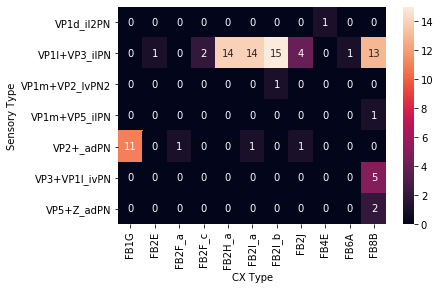

In [323]:
heat = sns.heatmap(direct_type,annot = True)
plt.show()